# Supercritical pitchfork bifurcation of a column
This notebook shows the calculation of the supercritical pitchfork bifurcation of a pin-ended column loaded in compression with MSC Nastran SOL 106. We first recall the analytical results for a 1 DOF system and then we move on to the numerical computation.

* [1 DOF system](#1dof)
* [Numerical model](#numerical-model)
* [Subcases definition](#subcases-definition)
* [Full Newton method](#newton)
* [Arc-length method](#arc-length)
    * [Alternative subcase sequence](#alternative-subcase)
    * [Mixed methods](#mixed-methods)
    * [Reduced compression force](#reduced-compression)
* [Conclusions](#conclusions)

## 1 DOF system <a name="1dof"></a>
Let's take the 1 DOF system represented below, composed by two initially collinear rods with a linear torsional spring under axial compressive load $P$.

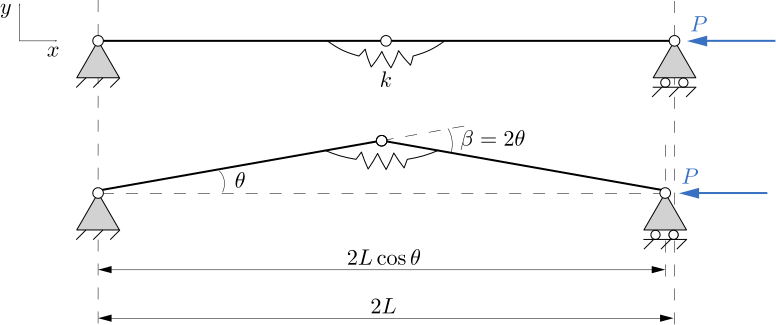

In [105]:
from IPython.display import SVG
SVG(filename='CollinearRods.svg')

The equilibrium equation is satisfied under two conditions:
$$\theta=0$$
$$\frac{P}{P_{cr}}=\frac{\theta}{\sin\theta}$$
where $\theta=0$ is the trivial solution and $P_{cr}=2k/L$ is the buckling load.

For $\theta=0$ the equilibrium is stable for $P<P_{cr}$, while for $P/P_{cr}=\theta/\sin\theta$ the equilibrium is always stable.

If we add an imperfection to the system, like the initial angle $\theta_0$ shown below, the equilibrium changes.

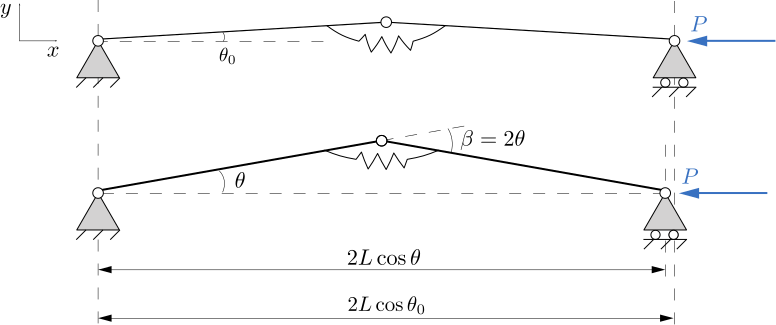

In [106]:
SVG(filename='ImperfectionRods.svg')

The symmetry of the problem is broken and the equilibrium is found for the following condition:
$$\frac{P}{P_{cr}}=\frac{\theta-\theta_0}{\sin\theta}$$

If we plot the results we can observe the supercritical pitchfork bifurcation and the broken pitchfork.

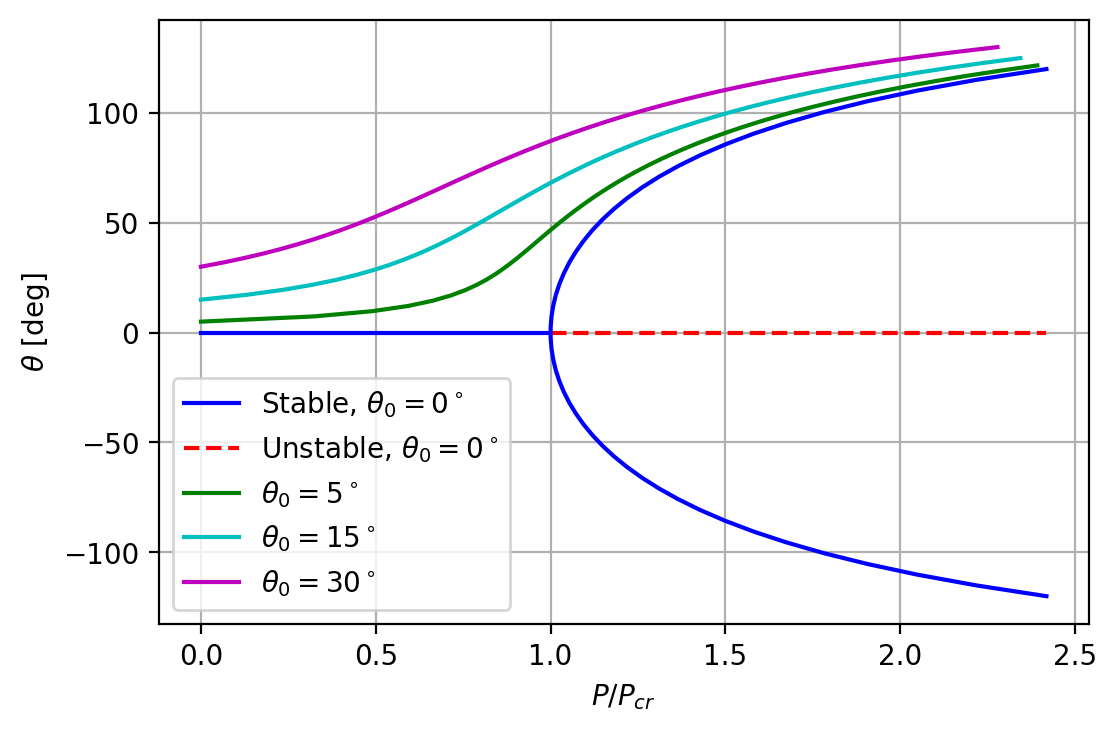

In [107]:
# Import matplotlib
import matplotlib.pyplot as plt
# Render static images
%matplotlib inline
plt.rcParams['figure.dpi'] = 200
# Render interactive figures
# %matplotlib notebook
# Create figure
fig, ax = plt.subplots()

# Perfect system
import numpy as np
theta_trivial_stable = np.array([0., 0.])  # deg
load_trivial_stable = np.array([0., 1.])
theta_stable = np.linspace(-120, 120)  # deg
load_stable = np.deg2rad(theta_stable)/np.sin(np.deg2rad(theta_stable))
theta_trivial_unstable = np.array([0., 0.])  # deg
load_trivial_unstable = np.array([1., np.max(load_stable)])
style = {'stable': '-b', 'unstable': '--r'}
ax.plot(load_trivial_stable, theta_trivial_stable, style['stable'], label='Stable, $\\theta_0 = 0^\circ$')
ax.plot(load_trivial_unstable, theta_trivial_unstable, style['unstable'], label='Unstable, $\\theta_0 = 0^\circ$')
ax.plot(load_stable, theta_stable, style['stable'])

# Imperfection
imperfections = [5, 15, 30]  # deg
style = {5: '-g', 15: '-c', 30: '-m'}
for theta_0 in imperfections:
    theta_imperfection = np.linspace(theta_0, 120 + theta_0/3)
    load_imperfection = (np.deg2rad(theta_imperfection-theta_0))/np.sin(np.deg2rad(theta_imperfection))
    ax.plot(load_imperfection, theta_imperfection, style[theta_0], label='$\\theta_0={:d}^\circ$'.format(theta_0))

# Set plot appearance
ax.set_xlabel('$P/P_{cr}$')
ax.set_ylabel('$\\theta$ [deg]')
ax.legend()
ax.grid()
plt.show()

## Numerical model <a name="numerical-model"></a>
We consider a constant cross-sectional column with the following characteristics (inspired by [this article](https://simcompanion.hexagon.com/customers/s/article/buckling-analysis-of-column-kb8021539)):
 * Young's modulus $E=207$ GPa
 * Poisson's ratio $\nu=0.3$
 * density $\rho=7.8\cdot10^{-4}$ tons/mm$^3$
 * diameter $d=20$ mm
 * length $l=420$ mm

The shear modulus $G$ will be calculated by Nastran according to the following equation:
$$E=2(1+\nu)G.$$

We discretize the column into 420 beam elements and we consider a two-dimensional problem in the $xy$ plane, so permanent single-point constraints for all nodes are enforced for the corresponding degrees of freedom. For the boundary conditions we define two single-point constraints: a pin support at one end of the column and a roller support at the other end.

With the mentioned input variables we call the `create_column_base_model` function, which returns a `BDF` object with our base model. Finally, we define the name of our model.

In [108]:
import column_buckling_utils
E = 207000.  # [MPa]
nu = 0.3
rho = 7.8e-4  # [tons/mm^3]
d = 20  # [mm]
l = 420  # [mm]
no_elements = 420
model = column_buckling_utils.create_column_base_model(E, nu, rho, d, l, no_elements)

subcase=0 already exists...skipping


Let's visualize some information about the model that we have just created.

In [109]:
print(model.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcadds[3]
  SPCADD:  1

bdf.spcs[1]
  SPC1:    1

bdf.spcs[2]
  SPC1:    1

bdf.params
  PARAM    : 2

bdf.nodes
  GRID     : 421

bdf.elements
  CBEAM    : 420

bdf.properties
  PBEAML   : 1

bdf.materials
  MAT1     : 1




Before moving on to the definition of the subcases, we calculate the buckling load using Euler's formula, so that we can nondimensionalize our results later.

In [110]:
I = np.pi*d**4/64  # [mm^4]
euler_buckling_load = np.pi**2*E*I/l**2  # [N]
print(f'Euler\'s buckling load: {euler_buckling_load:.2f} N')

Euler's buckling load: 90962.29 N


## Subcases definition <a name="subcases-definition"></a>
In order to reproduce the supercritical pitchfork bifurcation with our numerical model, we need to obtain the stable branch up to the buckling load, the unstable branch beyond the buckling load and one of the two symmetrical stable branches beyond the buckling load. In addition, we also want to visualize the broken pitchfork, in order to notice the influence of an initial imperfection or of an eccentricity in the oad. The approach to numerically reproduce the supercritical pitchfork bifurcation as described is to use the following succession of subcases.

1. Apply a compression load larger than the buckling load at the roller-supported end of the column. Initially this will move us along the straight stable branch of the pitchfork and as the load increases we will move on to the unstable branch.

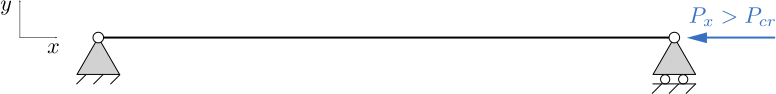

In [111]:
SVG(filename='Subcase1.svg')

2. Add a small transverse load at the middle of the column. This will break the symmetry of the problem and consequently the pitchfork, producing a certain deflection of the column.

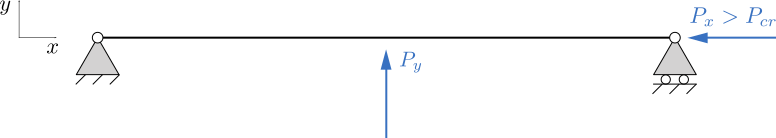

In [112]:
SVG(filename='Subcase2.svg')

3. Remove the transverse load in order to restore the symmetry of the problem. At this point also the pitchfork will be restored and the column will move onto the stable branch corresponding to the direction of the tranverse load that was applied in the previous subcase. As a consequence it will still be possible to observe a nonzero deflection of the column.

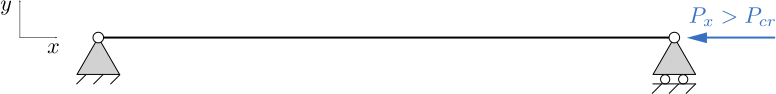

In [113]:
SVG(filename='Subcase1.svg')

4. Remove the compression load. This will move us along the curved stable branch until we get back to the straight stable branch and we sweep it back to the undeformed state of the column.

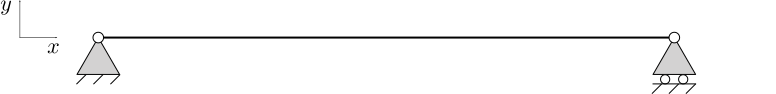

In [114]:
SVG(filename='Subcase4.svg')

5. Apply both the compression and the transverse load at the same time. This will let us visualize the equilibrium path of the broken pitchfork.

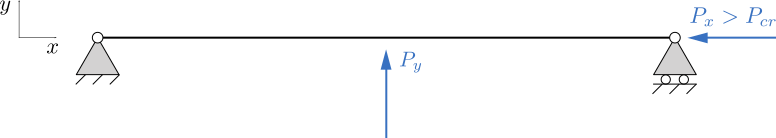

In [115]:
SVG(filename='Subcase2.svg')

Let's start by choosing a name for our model.

In [116]:
model_name = 'column_pitchfork_bifurcation'

 Then we define the compression force and the transverse force, which we will later assign to the different load sets. We consider a compression force equal to twice the Euler buckling load, $P_x/P_{cr}=2$ while we set the transverse force as a fraction of the buckling load $P_y/P_{cr}=1/100$.

In [117]:
# Compression force definition
compression_force_sid = list(model.spcadds.keys())[0]+1
last_node_id = no_elements+1
compression_force_magnitude = euler_buckling_load*2
compression_force_direction = [-1., 0., 0.]
model.add_force(sid=compression_force_sid, node=last_node_id, mag=compression_force_magnitude, xyz=compression_force_direction)
# Transverse force definition
transverse_force_sid = compression_force_sid+1
middle_node_id = int(no_elements/2+1)
transverse_force_magnitude = euler_buckling_load/100
transverse_force_direction = [0., 1., 0.]
model.add_force(sid=transverse_force_sid, node=middle_node_id, mag=transverse_force_magnitude, xyz=transverse_force_direction)

FORCE          5     211        909.6229      0.      1.      0.

Now we define the different load combinations that we are going to use in our subcases. We consider three load combinations: one with compression force only, one with compression and transverse force and one with no applied force.

In [118]:
# Only compression force
compression_load_sid = transverse_force_sid+1
model.add_load(compression_load_sid, scale=1., scale_factors=[1.], load_ids=[compression_force_sid])
# Compression and transverse forces
combined_load_sid = compression_load_sid+1
model.add_load(combined_load_sid, scale=1., scale_factors=[1., 1.], load_ids=[compression_force_sid, transverse_force_sid])
# No force applied
zero_load_sid = combined_load_sid+1
model.add_load(zero_load_sid, scale=1., scale_factors=[0.], load_ids=[compression_force_sid])

LOAD           8      1.      0.       4

Let's define the first subcase and the corresponding load set, which includes only the compression force $P_x$.

In [119]:
import utils
utils.create_static_load_subcase(model, subcase_id=1, subtitle='Apply compression load', load_sid=compression_force_sid)

We proceed with the second subcase, where we add the transverse force $P_y$.

In [120]:
utils.create_static_load_subcase(model, subcase_id=2, subtitle='Add transverse load', load_sid=combined_load_sid)

We then define the third subcase, where we remove the transverse force $P_y$.

In [121]:
utils.create_static_load_subcase(model, subcase_id=3, subtitle='Remove transverse load', load_sid=compression_load_sid)

Now we define the fourth subcase, where we remove also the compression force $P_x$.

In [122]:
utils.create_static_load_subcase(model, subcase_id=4, subtitle='Remove compression load', load_sid=zero_load_sid)

Finally we define the fifth subcase, where we apply both the compression and the transverse load together.

In [123]:
utils.create_static_load_subcase(model, subcase_id=5, subtitle='Apply compression and transverse load', load_sid=combined_load_sid)

## SOL 106 <a name="sol106"></a>
### Full Newton method <a name="newton"></a>
We choose SOL 106 as solution sequence and we set the parameters for the nonlinear iteration strategy to use the full Newton method. For this purpose, we define a `NLPARM` card with the following parameters:
* `ninc=100` to set the number of load increments
* `kmethod='ITER'` and `kstep=1` to update the stiffness matrix at every iteration
* `max_iter=25` to set the maximum number of iterations for each load increment
* `conv='PV'` to select convergence criteria based on load equilibrium error with vector component method
* `int_out='YES'` to process the output for every computed load increment
* `eps_p=1e-3` to set the error tolerance for the load criteria
* `max_bisect=10` to set the maximum number of bisections allowed for each load increment

We assign the id of the `NLPARM` card as default for all subcases.

In [124]:
model.sol = 106
nlparm_id = 1
model.add_nlparm(nlparm_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
model.case_control_deck.subcases[0].add_integer_type('NLPARM', nlparm_id)

We also need to define the additional parameter `PARAM,LGDISP,1` to assume all nonlinear structural element types with large displacement capability to have large displacement effects.

In [125]:
model.add_param('LGDISP', [1])

PARAM     LGDISP       1

Now let’s create an appropriate directory where we can run the analysis and let’s write our BDF object to an actual bdf file. Successively, we run the analysis with Nastran.

In [126]:
import os
# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationFullNewtonMethod'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, model, model_name, run_flag=False)

Once the analysis is done, we can read the op2 file and look for the load step, the rotation $\theta$ at the pin-supported node (having ID=1) and the applied load along $x$ and $y$ for every subcase and every nonlinear iteration step.

In [127]:
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, model_name + '.op2')
# Get output data from op2 file
load_step, rotation_rad, applied_load_x, applied_load_y = utils.read_equilibrium_path_data_from_op2(op2_file_path, displacement_node_id=1, displacement_index=5, load1_index=0, load2_index=1)
# Convert rotation angles from radians to degrees
rotation_deg = {k:np.rad2deg(v) for k, v in rotation_rad.items()}

We can now plot the results of our analysis. For each converged iteration of each subcase we plot:
 * load step versus $\theta$
 * applied load along $x$ versus $\theta$
 * applied load along $y$ versus $\theta$

In addition we print the value of $\theta$ at the end of each subcase.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = 124.34 degrees
Subcase 3: theta = 124.39 degrees
Subcase 4: theta = 0.00 degrees
Subcase 5: theta = 124.34 degrees


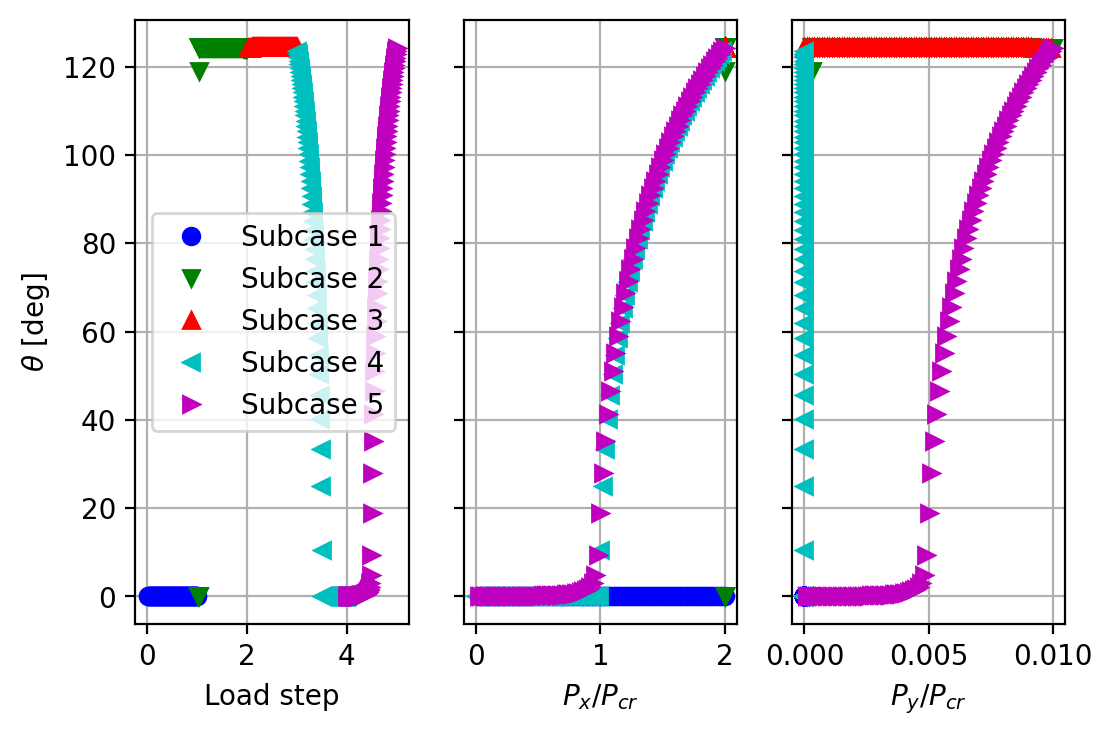

In [128]:
def plot_2d_equilibrium_paths(theta, load_step, P_x, P_y):
    # Set plotting style for different subcases
    style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m', 6: '1y', 7: '2k'}
    # Create figure with subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey='all')
    # Iterate over the subcases
    for subcase_id in theta:
        # Print rotation at the end of subcase
        print(f'Subcase {subcase_id:d}: theta = {theta[subcase_id][-1]:.2f} degrees')
        # Plot load step vs rotation
        axs[0].plot(load_step[subcase_id], theta[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along x vs rotation
        axs[1].plot(P_x[subcase_id]/euler_buckling_load, theta[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
        # Plot applied load along y vs rotation
        axs[2].plot(P_y[subcase_id]/euler_buckling_load, theta[subcase_id], style[subcase_id], label='Subcase {:d}'.format(subcase_id))
    # Set plot appearance
    axs[0].set_xlabel('Load step')
    axs[0].set_ylabel('$\\theta$ [deg]')
    axs[0].grid(visible=True)
    axs[1].set_xlabel('$P_x/P_{cr}$')
    axs[1].grid(visible=True)
    axs[2].set_xlabel('$P_y/P_{cr}$')
    axs[2].grid(visible=True)
    axs[0].legend()
    # Show plot
    plt.show()

plot_2d_equilibrium_paths(rotation_deg, load_step, applied_load_x, applied_load_y)

The following can be observed for the different subcases.
* During the first subcase the rotation $\theta$ is always null. We first move along the stable branch of the equilibrium diagram ($P_x/P_{cr}<1$) and then along the unstable branch ($P_x/P_{cr}>1$).
* In subcase 2, $\theta$ jumps from zero to about 124 degrees, moving from the unstable branch to a point laying on the broken pitchfork corresponding to the value of transverse force applied.
* During the third subcase we move from the broken pitchfork to a point on the curved stable branch of the equilibrium diagram. Unexpectedly, at the end of the subcase $\theta$ is slightly smaller with respect to the value at the end of subcase 2. This is in contrast with the results of the 1 DOF system, where the imperfect structure always shows a larger value of $\theta$ for the same applied load $P_x/P_{cr}$.
* In subcase 4, we move along the curved stable branch as the column is unloaded and for $P_x/P_{cr}<1$ we traverse the flat stable branch until we get back to a null rotation.
* Finally, during subcase 5 the column is loaded with both the compression and the transverse force and we can observe the equilibrium path corresponding to the broken pitchfork. In particular, it is evident how the path of the broken pitchfork deviates from the one of the "pristine" pitchfork for $P_x/P_{cr}<1$. The final value of $\theta$ corresponds to the one obtained for the second subcase.

We can also plot the equilibrium diagram in 3D, adding $P_y/P_{cr}$ as $z$ axis.

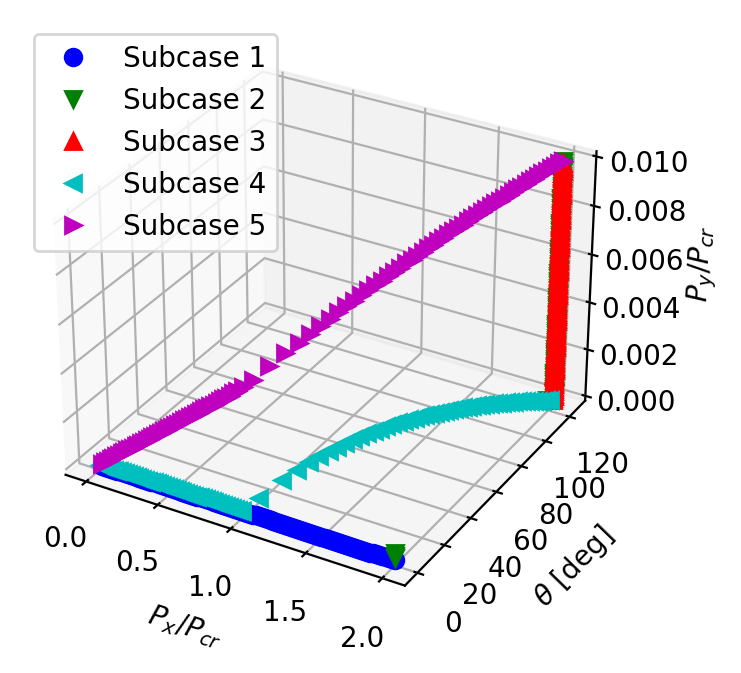

In [129]:
from mpl_toolkits import mplot3d
def plot_3d_equilibrium_paths(theta, P_x, P_y):
    # Set plotting style for different subcases
    style = {1: 'ob', 2: 'vg', 3: '^r', 4: '<c', 5: '>m', 6: '1y', 7: '2k'}
    # Create figure with three-dimensional axes
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    for subcase_id in theta:
        # Plot load applied along x vs rotation of pin-supported node vs applied along y
        ax.plot3D(P_x[subcase_id]/euler_buckling_load, theta[subcase_id], P_y[subcase_id]/euler_buckling_load, style[subcase_id], label='Subcase {:d}'.format(subcase_id))
    ax.set_xlabel('$P_x/P_{cr}$')
    ax.set_ylabel('$\\theta$ [deg]')
    ax.set_zlabel('$P_y/P_{cr}$')
    ax.legend()
    ax.grid(visible=True)
    plt.show()

plot_3d_equilibrium_paths(rotation_deg, applied_load_x, applied_load_y)

Here we can recognize equilibrium path of the classical supercritical pitchfork bifurcation on the $P_x/P_{cr}-\theta$ plane and the jump of $\theta$ during subcase 2. We remind that the employed Newton method is based on load control, so the jump in subcase 2 suggests the presence of a limit point, which we should be able to observe calculating the equilibrium path with the arc-length method. Finally, the 3D view enables the observation of two features.
* The path of the broken pitchfork is actually three-dimensional when we also consider the transverse load as an independent parameter of the system.
* The "pristine" and the broken pitchfork are connected by the equilibrium path found in subcase 3.

### Arc-length method <a name="arc-length"></a>
Now we try to analyze the supercritical pitchfork bifurcation using the arc-length incremental solution strategy. For this purpose we define a `NLPCI` card with the following parameters.
* `Type='CRIS'` to set Crisfield constraint type.
* `minalr=.01` and `maxalr=1.1` to set the minimum and maximum allowable arc-length adjustment ratio between increments, $MINALR \leq\frac{\Delta l_{new}}{\Delta l_{old}}\leq MAXALR$. Smaller values of $MAXALR$ were tested, but the analysis appeared to get stuck during subcase 4 around the bifurcation point.
* `desiter=5` to set the desired number of iterations for convergence, which is used for the arc-length adjustment: $\Delta l_{new}=\Delta l_{old}\sqrt{DESITER/I_{max}}$ (where $I_{max}$ represents the number of iterations required for convergence in the previous load increment).
* `mxinc=2000` to set the maximum number of controlled increment steps allowed within a subcase.

In [130]:
model.add_nlpci(nlparm_id, Type='CRIS', minalr=.01, maxalr=1.1, desiter=5, mxinc=2000)

NLPCI          1    CRIS     .01     1.1      0.               5    2000

We create the analysis directory, write the bdf file and run the analysis with Nastran.

In [131]:
# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationArcLength'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, model, model_name, run_flag=False)

Analogously to the full Newton method case, we read the op2 file and we store the load step, the rotation $\theta$ and the applied load along $x$ and $y$ for every subcase and every iteration step. Successively, we plot the results in the same way as we did previously.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -0.38 degrees
Subcase 3: theta = 0.00 degrees
Subcase 4: theta = 0.00 degrees
Subcase 5: theta = 124.34 degrees


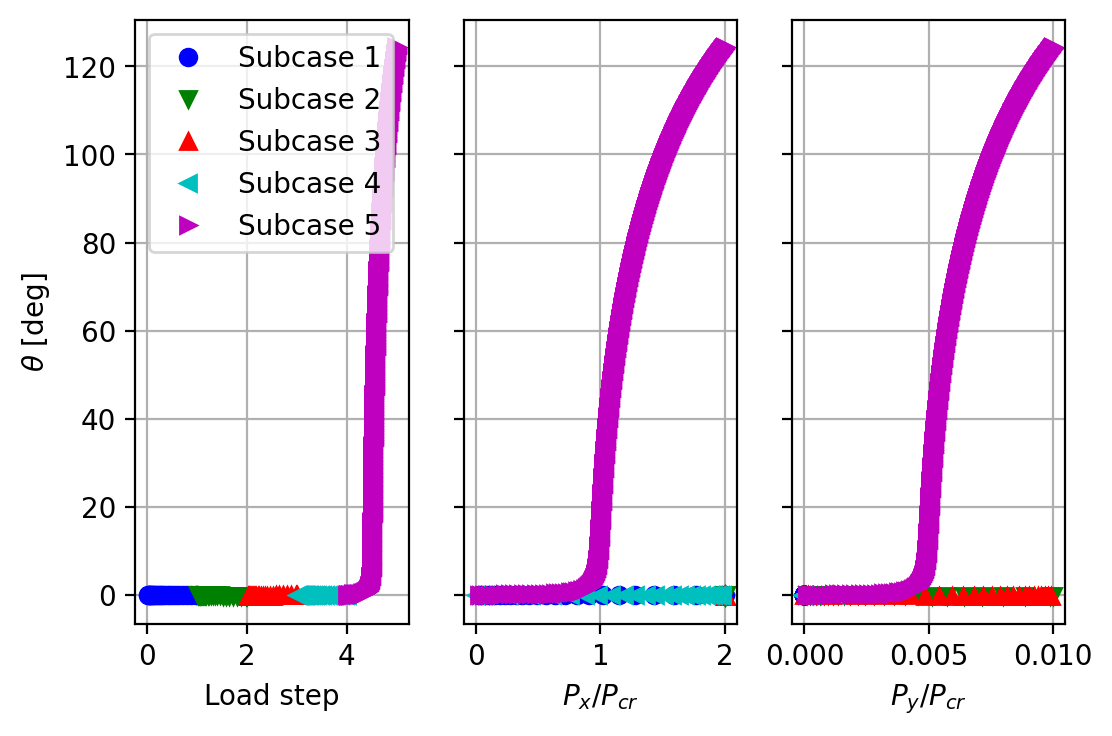

In [132]:
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, model_name + '.op2')
# Get output data from op2 file
load_step, rotation_rad, applied_load_x, applied_load_y = utils.read_equilibrium_path_data_from_op2(op2_file_path, displacement_node_id=1, displacement_index=5, load1_index=0, load2_index=1)
# Convert rotation angles from radians to degrees
rotation_deg = {k:np.rad2deg(v) for k, v in rotation_rad.items()}
# Plot 2d results
plot_2d_equilibrium_paths(rotation_deg, load_step, applied_load_x, applied_load_y)

We can easily observe some differences with respect to the full Newton method case.
* Only the equilibrium path of the broken pitchfork is obtained, while the "pristine" pitchfork is not captured. More in particular, the analysis can successfully traverse the flat stable and unstable branches, but it fails to switch from the flat unstable branch to the branch of the broken pitchfork during subcase 2.
* The value of $\theta$ at the end of the second subcase is slightly negative. This appears to be counterintuitive, as it means that the column is deflecting towards the opposite direction with respect to the one of the applied transverse load.

Also in this case we can plot the equilibrium diagram in 3D.

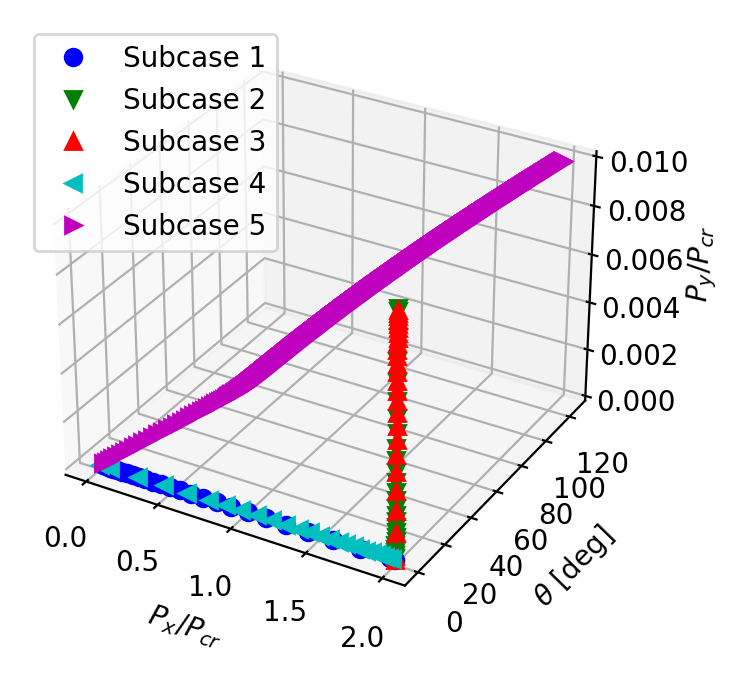

In [133]:
# Plot 3d results
plot_3d_equilibrium_paths(rotation_deg, applied_load_x, applied_load_y)

Considering the jump that we observed with the Newton method in subcase 2 we would expect to observe a limit point with the arc-length method. However, we cannot see any evidence of such limit point, rather we follow an equilibrium path with slightly negative values of $\theta$. As a consequence, we need to investigate the equilibrium path around $P_x/P_{cr}=2$ more in detail.

We copy the previous model object and we choose a name for the new analysis.

In [134]:
investigation_model = model.__deepcopy__({})
investigation_model_name = 'column_pitchfork_bifurcation_investigation_PxPcr_2'

We define the subcases in the following way.
1. Subcase 1 stays unchanged.
2. In subcase 2 we keep the compression force and apply a large transverse force, setting $P_y/P_{cr}=100$, in order to examine in detail the equilibrium path.
3. In subcase 3 we keep the compression force, remove the transverse force and apply another transverse force with $P_y/P_{cr}=-100$, so equal but in opposite direction with respect to the force applied in subcase 2. In this way we study the other side of the equilibrium path.
4. Subcases 4 and 5 are removed.

We use the same NLPARM and NLPCI cards used previously. Smaller values of MAXALR were also tested, but no significant change in the results was observed.

In [135]:
# Remove subcases 4 and 5
del investigation_model.subcases[4]
del investigation_model.subcases[5]
# Modify magnitude of transverse force in subcase 2
investigation_model.loads[transverse_force_sid][0].mag = euler_buckling_load*100
# Add new load combination with transverse load in opposite direction
combined_load_opposite_direction_sid = zero_load_sid+1
force_sids = [compression_force_sid, transverse_force_sid]
scale_factors = [1., -1.]
investigation_model.add_load(combined_load_opposite_direction_sid, 1., scale_factors, force_sids)
# Modify subcase 3
investigation_model.subcases[3].params['LOAD'][0] = combined_load_opposite_direction_sid
investigation_model.subcases[3].params['SUBTITLE'][0] = 'Add transverse load in opposite direction'

Let's create the analysis directory, write the bdf file and run the analysis.

In [136]:
# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationArcLength'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, investigation_model, investigation_model_name, run_flag=False)

And now let's read the op2 file and visualize the results.

Subcase 1: theta = 0.00 degrees
Subcase 2: theta = -256.48 degrees
Subcase 3: theta = 256.49 degrees


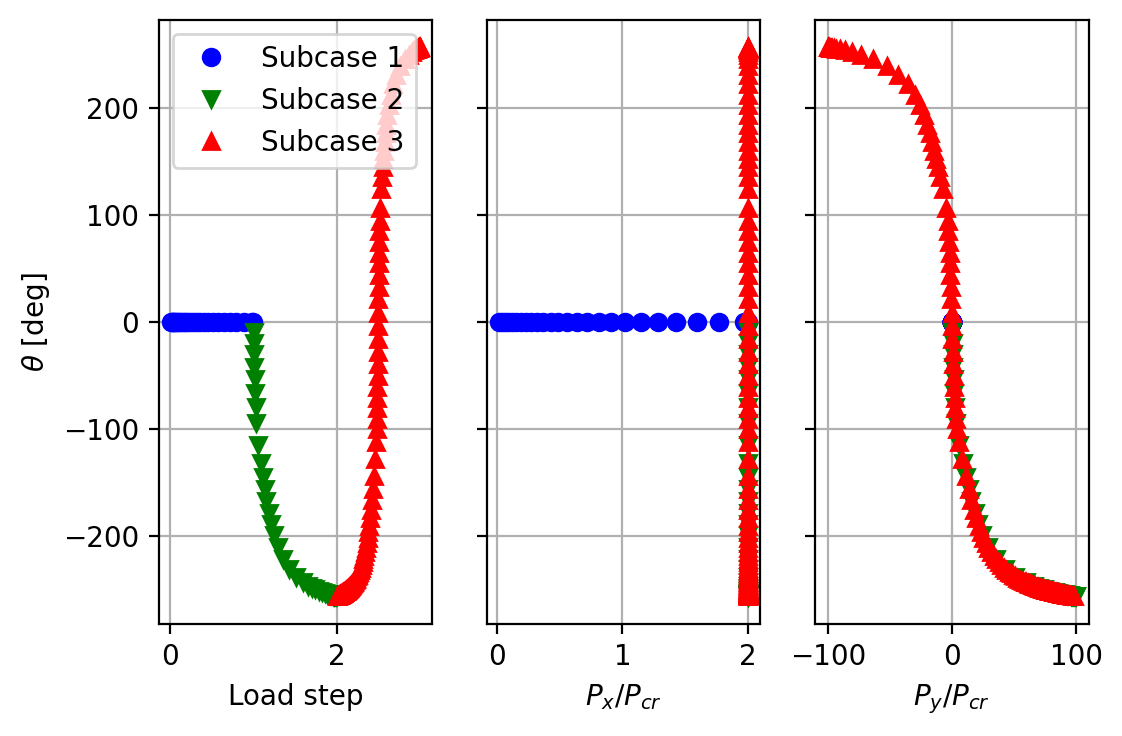

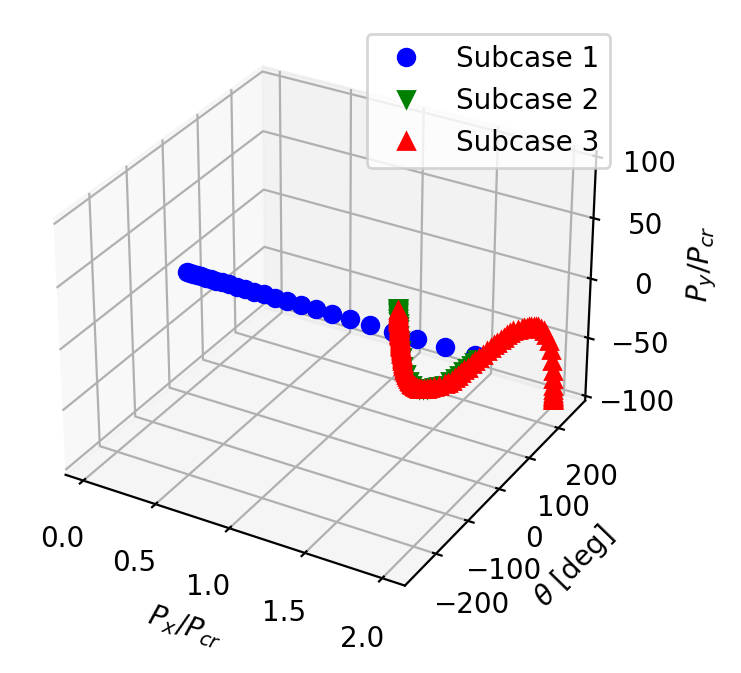

In [137]:
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, investigation_model_name + '.op2')
# Get output data from op2 file
load_step, rotation_rad, applied_load_x, applied_load_y = utils.read_equilibrium_path_data_from_op2(op2_file_path, displacement_node_id=1, displacement_index=5, load1_index=0, load2_index=1)
# Convert rotation angles from radians to degrees
rotation_deg = {k:np.rad2deg(v) for k, v in rotation_rad.items()}
# Plot 2d results
plot_2d_equilibrium_paths(rotation_deg, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_equilibrium_paths(rotation_deg, applied_load_x, applied_load_y)

From the results it appears that the equilibrium path on the $P_x/P_{cr}=2$ plane predicts a downward deflection of the column for an upward transverse force and vice versa. Once again, we cannot observe the presence of a limit point and the equilibrium path does not seem to justify the jump that we observed with the Newton method.

#### Alternative subcase sequence <a name="alternative-subcase"></a>
Let's try a different sequence of subcases to investigate the equilibrium path on the $P_x/P_{cr}=2$ plane.
1. Apply combined compression and transverse force, with $P_x/P_{cr}=2$ and $P_y/P_{cr}=1/100$. In this way we move along the equilibrium path of the broken pitchfork.
2. Keep the compression load and reverse the transverse load, setting $P_y/P_{cr}=-100$. The idea here is to observe whether we are able to switch from one side of the broken pitchfork to the other side. We set a larger magnitude for the transverse load to overcome potential limit points in the equilibrium path.

We proceed with copying the original model and with modifying the subcases.

In [138]:
# Copy bdf object and define new name
alternative_subcases_model = model.__deepcopy__({})
alternative_subcases_model_name = 'column_pitchfork_bifurcation_alternative_subcases'
# Modify subcase 1
alternative_subcases_model.subcases[1].params['LOAD'][0] = combined_load_sid
alternative_subcases_model.subcases[1].params['SUBTITLE'][0] = 'Apply compression and transverse load'
# Add load combination with transverse load in opposite direction
force_sids = [compression_force_sid, transverse_force_sid]
scale_factors = [1., -10000.]
alternative_subcases_model.add_load(combined_load_opposite_direction_sid, 1., scale_factors, force_sids)
# Modify subcase 2
alternative_subcases_model.subcases[2].params['LOAD'][0] = combined_load_opposite_direction_sid
alternative_subcases_model.subcases[2].params['SUBTITLE'][0] = 'Apply transverse load in opposite direction'
# Remove subcases 3 to 5
del alternative_subcases_model.subcases[3]
del alternative_subcases_model.subcases[4]
del alternative_subcases_model.subcases[5]

Once again, we create the analysis directory, write the bdf file, run the analysis, read the op2 file and plot the results.

Subcase 1: theta = 124.34 degrees
Subcase 2: theta = 90.02 degrees


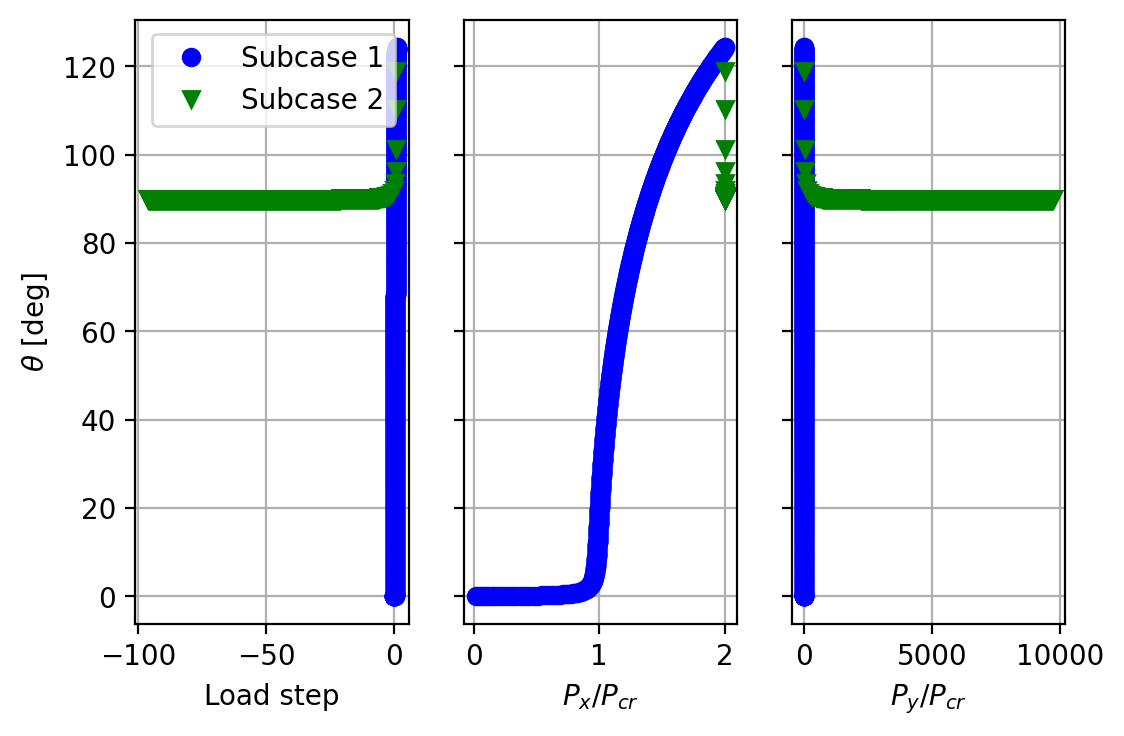

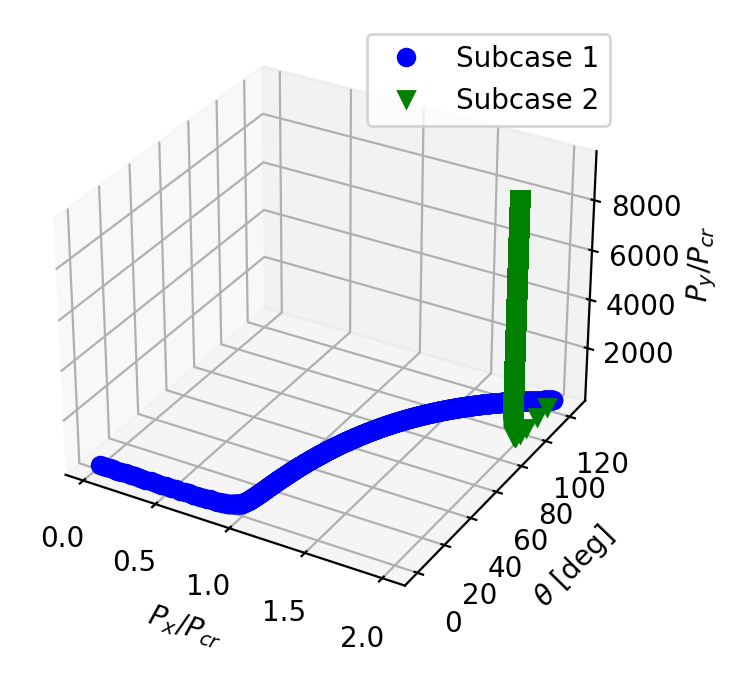

In [139]:
# Define name of analysis directory
analysis_directory_name = 'PitchforkBifurcationArcLength'
analysis_directory_path = os.path.join(os.getcwd(), analysis_directory_name)
# Run analysis
utils.run_analysis(analysis_directory_path, alternative_subcases_model, alternative_subcases_model_name, run_flag=False)
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, alternative_subcases_model_name + '.op2')
# Get output data from op2 file
load_step, rotation_rad, applied_load_x, applied_load_y = utils.read_equilibrium_path_data_from_op2(op2_file_path, displacement_node_id=1, displacement_index=5, load1_index=0, load2_index=1)
# Convert rotation angles from radians to degrees
rotation_deg = {k:np.rad2deg(v) for k, v in rotation_rad.items()}
# Plot 2d results
plot_2d_equilibrium_paths(rotation_deg, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_equilibrium_paths(rotation_deg, applied_load_x, applied_load_y)

The nonlinear analysis does not converge to the desired load in subcase 2. We can observe negative load steps, indicating that the arc-length tries to seek a root in the loading direction of the previous subcase. As a consequence, the arc-length solver applies an increasing upward force instead of applying the defined downward force. The analysis stops because the maximum number of increments is reached.

##### Mixed methods <a name="mixed-methods"></a>
Since the arc-length method seems to encounter issues when the sign of the transverse force is inverted, we try to repeat the analysis substituting the arc-length method with the full Newton method in subcase 2.

For this purpose we first add another `NLPARM` card to the model and assign its id to subcase 2.

In [140]:
# Copy bdf object and define new name
mixed_methods_model_name = 'column_pitchfork_bifurcation_mixed_methods'
# Define NLPARM card for Newton method
nlparm2_id = 2
alternative_subcases_model.add_nlparm(nlparm2_id, ninc=100, kmethod='ITER', kstep=1, max_iter=25, conv='PV', int_out='YES', eps_p=1e-3, max_bisect=10)
# Set NLPARM id of second subcase
alternative_subcases_model.case_control_deck.subcases[2].add_integer_type('NLPARM', nlparm2_id)

Then we run the analysis and plot the results.

Subcase 1: theta = 124.34 degrees
Subcase 2: theta = 267.67 degrees


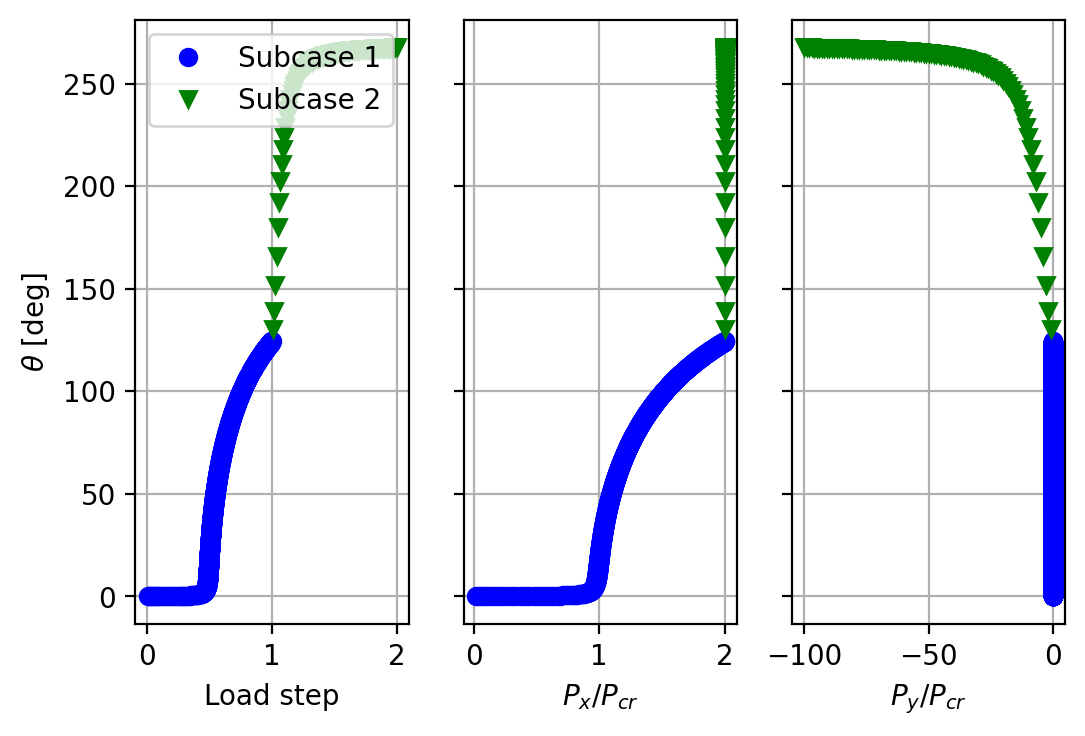

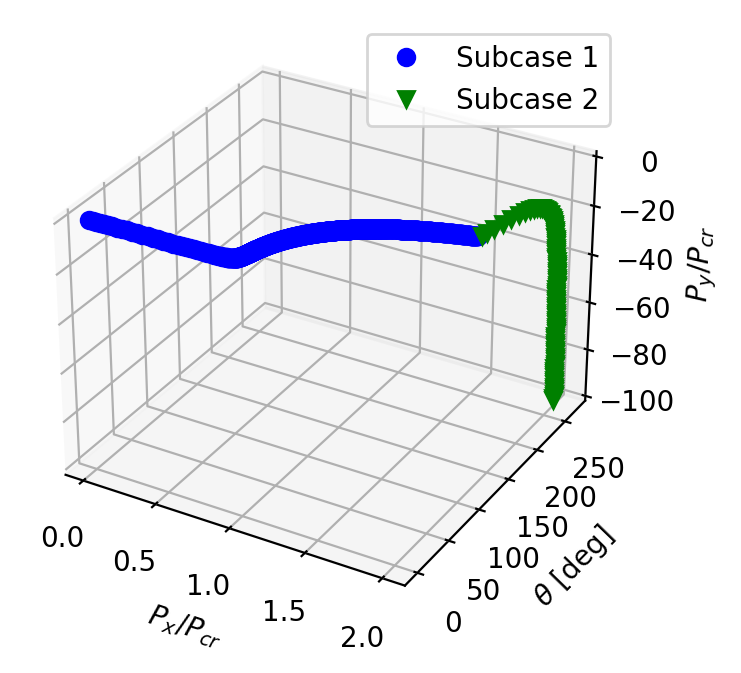

In [141]:
# Run analysis
utils.run_analysis(analysis_directory_path, alternative_subcases_model, mixed_methods_model_name, run_flag=False)
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, mixed_methods_model_name + '.op2')
# Get output data from op2 file
load_step, rotation_rad, applied_load_x, applied_load_y = utils.read_equilibrium_path_data_from_op2(op2_file_path, displacement_node_id=1, displacement_index=5, load1_index=0, load2_index=1)
# Convert rotation angles from radians to degrees
rotation_deg = {k:np.rad2deg(v) for k, v in rotation_rad.items()}
# Plot 2d results
plot_2d_equilibrium_paths(rotation_deg, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_equilibrium_paths(rotation_deg, applied_load_x, applied_load_y)

We observe that with the Newton method we are able to traverse the equilibrium path for negative values of $P_y/P_{cr}$. However, we notice that for the investigated range of transverse loads, the equilibrium path does not seem to point towards the other side of the broken pitchfork.

##### Reduced compression force <a name="reduced-compression"></a>
At this point we want to assess whether the equilibrium path around a point on the broken pitchfork changes with the $P_x/P_{cr}$ coordinate, so whether it is influenced by the applied compression force. We attempt the same analysis shown in the [Alternative subcase sequence](#alternative-subcase) section using the following values of $P_x/P_{cr}$: 1.1, 1.4, 1.7. For each value of $P_x/P_{cr}$ we adjust the value of $P_y/P_{cr}$ in the second subcase. The reason for this will be evident when looking at the results.

We proceed with modifying the subcases, running the analysis and plotting the results for each value of $P_x/P_{cr}$.

Px/Pcr=1.1


Subcase 1: theta = 51.65 degrees
Subcase 2: theta = -59.52 degrees


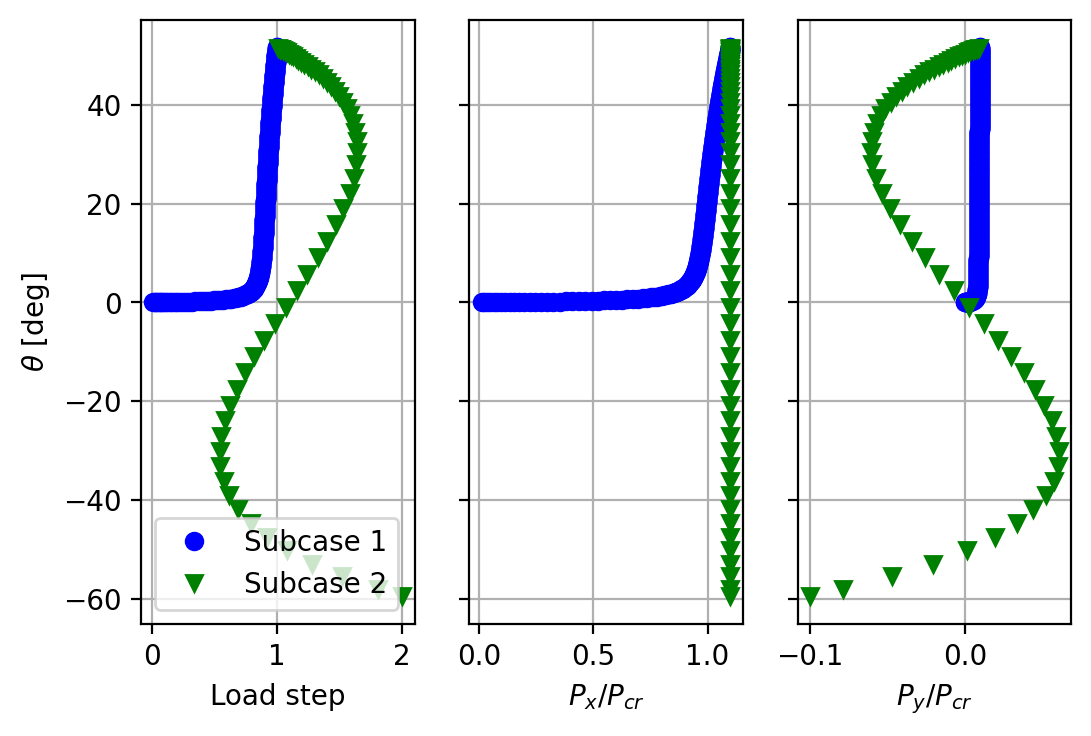

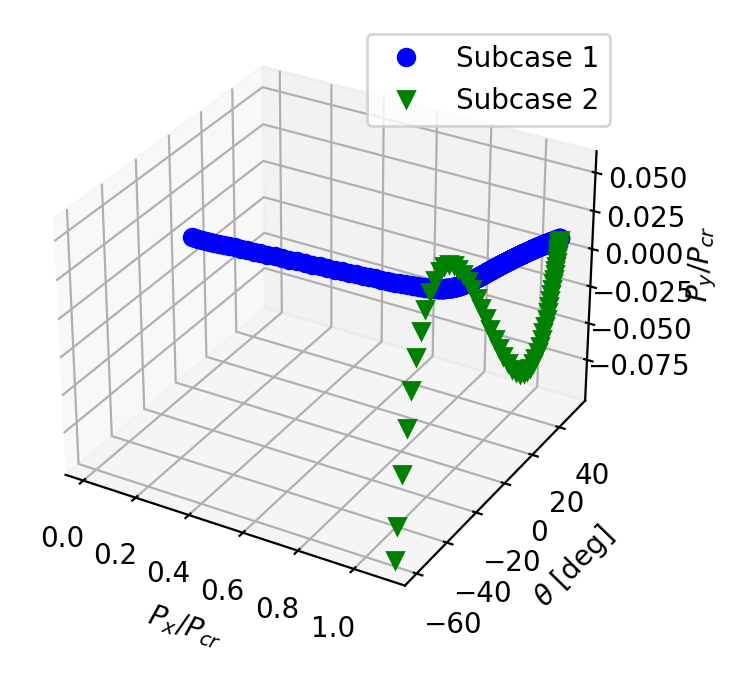

Px/Pcr=1.4


Subcase 1: theta = 90.89 degrees
Subcase 2: theta = -97.30 degrees


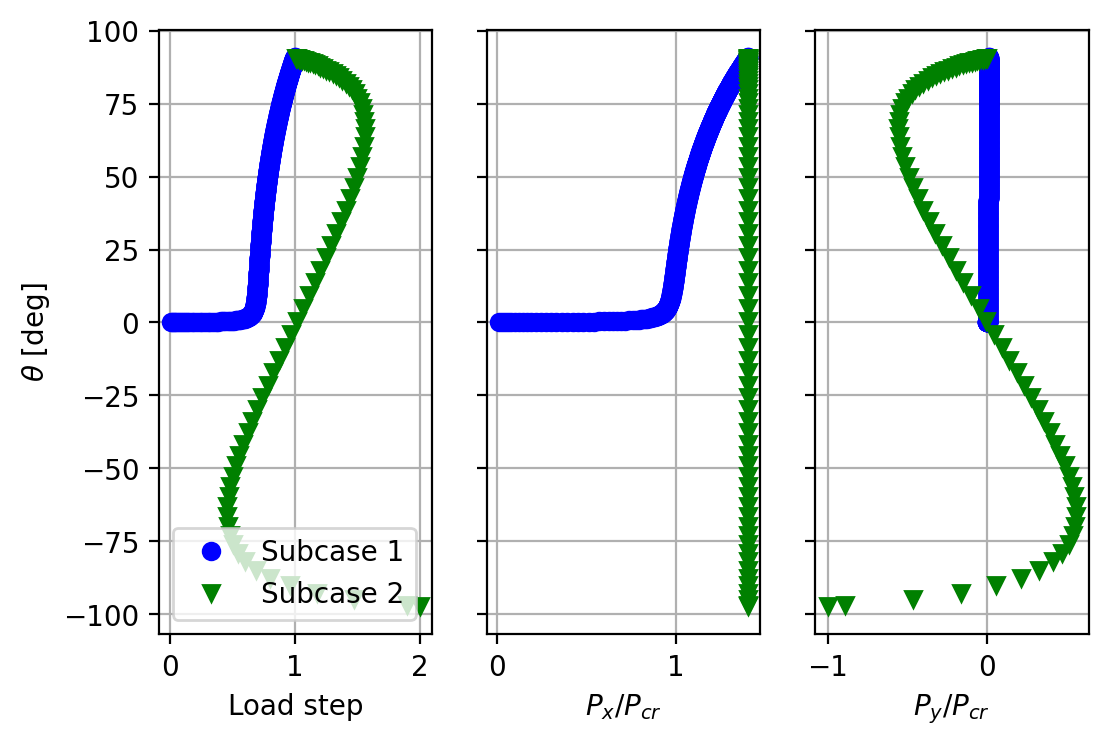

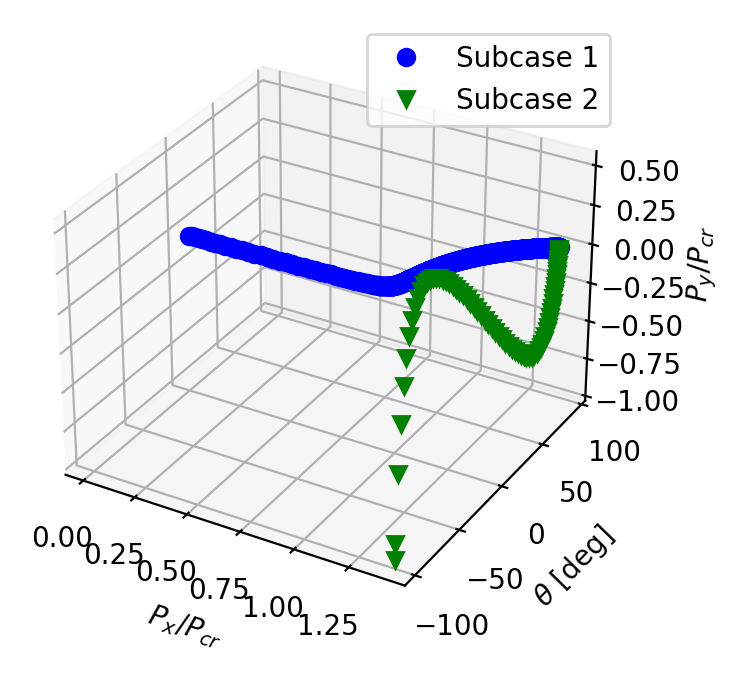

Px/Pcr=1.7


Subcase 1: theta = 111.14 degrees
Subcase 2: theta = -105.78 degrees


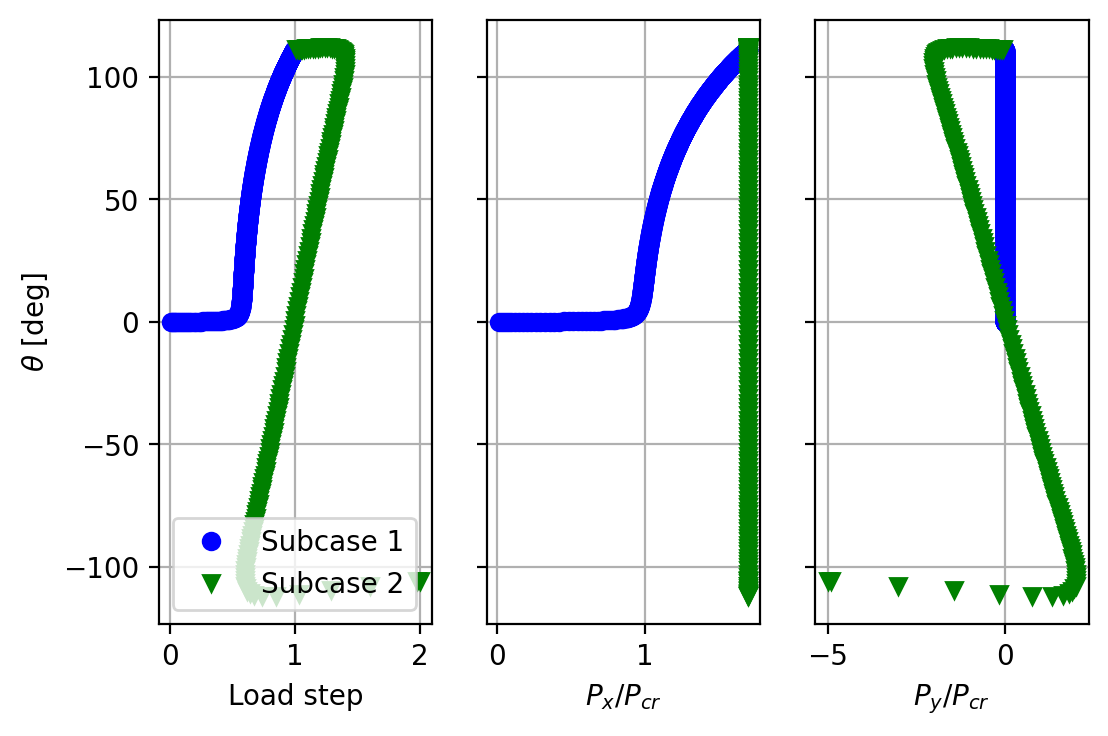

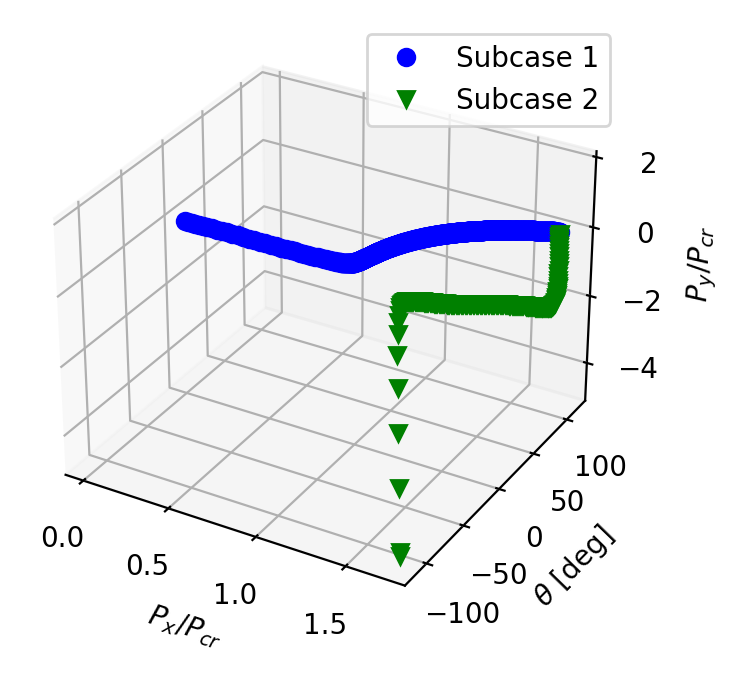

In [142]:
# Set the NLPARM id of subcase 2 to the id of the NLPARM card defining the arc-length method
alternative_subcases_model.subcases[2].params['NLPARM'][0] = nlparm_id
# Define values of Px/Pcr
compression_force_factors = [1.1, 1.4, 1.7]
# Define values of Py/Pcr
transverse_load_factors = [-1e1, -1e2, -5e2]
# Iterate through the different values of Px/Pcr and Py/Pcr
for force_factor, scale_factor in zip(compression_force_factors, transverse_load_factors):
    # Print value of compression force
    print('\033[1m' + f'Px/Pcr={force_factor:.1f}' + '\033[0m')
    # Define model name
    reduced_compression_force_model_name = f'column_pitchfork_bifurcation_PxPcr_{force_factor:.1f}'.replace('.','_')
    # Modify magnitude of compression force
    alternative_subcases_model.loads[compression_force_sid][0].mag = euler_buckling_load*force_factor
    # Modify scale factor of transverse load in subcase 2
    alternative_subcases_model.load_combinations[combined_load_opposite_direction_sid][0].scale_factors[1] = scale_factor
    # Run analysis
    utils.run_analysis(analysis_directory_path, alternative_subcases_model, reduced_compression_force_model_name, run_flag=False)
    # Define name of op2 file
    op2_file_path = os.path.join(analysis_directory_path, reduced_compression_force_model_name + '.op2')
    # Get output data from op2 file
    load_step, rotation_rad, applied_load_x, applied_load_y = utils.read_equilibrium_path_data_from_op2(op2_file_path, displacement_node_id=1, displacement_index=5, load1_index=0, load2_index=1)
    # Convert rotation angles from radians to degrees
    rotation_deg = {k:np.rad2deg(v) for k, v in rotation_rad.items()}
    # Plot 2d results
    plot_2d_equilibrium_paths(rotation_deg, load_step, applied_load_x, applied_load_y)
    # Plot 3d results
    plot_3d_equilibrium_paths(rotation_deg, applied_load_x, applied_load_y)

The results of these analyses show the presence of a snap-through behavior when moving from one side to the other of the broken pitchfork. Subcase 1 brings the structure onto a point of the broken pitchfork corresponding to an upward deflection of the column (positive $\theta$), that is a stable point. In subcase 2 the positive transverse force is gradually unloaded and the negative transverse force is loaded on the structure. As a consequence, during this process the transverse force becomes null and then negative with increasing magnitude, until a limit point is encountered. After this point the transverse force decreases in magnitude until it becomes null and changes sign. Once again, the force increases in magnitude until it encounters another limit point, this time for a positive force. Subsequently, the force decreases in magnitude, becomes null, changes its sign back to negative and finally achieves the value set in the definition of the subcase.

It should be noted that $P_y$ becomes null three times along the equilibrium path. Once for a positive value of $\theta$, once for $\theta=0$ and once for a negative value of $\theta$. This means that when moving from one side of the broken pitchfork to the other, the equilibrium path crosses the branches of the pristine pitchfork, where $P_y$ is null.

Furthermore, we can observe that the curve that describes the equilibrium path connecting the two sides of the pitchfork changes with the compression load $P_x$. Not only the location of the limit points is different, but the general shape of the curve changes. For example, we can notice how the slope at the start of subcase 2 is different and if for $P_x/P_{cr}=1.1$ and $1.4$ the angle $\theta$ decreases, for $P_x/P_{cr}=1.7$ $\theta$ has a slight increase before becoming smaller along the curve. This means that the level of compression of the column influences the equilibrium path connecting the two sides of the pitchfork. As a consequence, it is possible that for $P_x/P_{cr}=2$ the equilibrium path becomes more complex and that we are not able to traverse it within the set maximum number of iterations.

Finally, looking at the equilibrium point where $P_y=0$ and $\theta=0$, we notice the same seemingly nonphysical behavior that we observed in a previous analysis, that is to say downward deflection (negative $\theta$) for upward force (positive $P_y$) and vice versa. This can be explained by the fact that the points on that equilibrium path are all unstable, so when the column has a slight upward deflection, a downward force is needed to keep it in equilibrium and to prevent it from snapping to the stable branch of the pitchfork. Analogously, when the column has a slight downward deflection, an equilibrium configuration can only be obtained with the application of an upward force that prevents the column from snapping further downward.

We conclude this series of analyses with an investigation on both sides of the pitchfork. We define the following subcases.

1. Move along the equilibrium path of the broken pitchfork applying combined compression and transverse force, with $P_x/P_{cr}=1.5$ and $P_y/P_{cr}=1/100$.
2. Remove the transverse load in order to land on an equilibrium point of the pristine pitchfork.
3. Apply a downward transverse load, setting $P_y/P_{cr}=-1$, to move to the other side of the pitchfork. The final equilibrium point belongs to the side of the broken pitchfork corresponding to a downward deflection of the column.
4. Analogously to subcase 2, remove the transverse load in order to get to an equilibrium point of the pristine pitchfork. In this subcase we want to verify that the rotation $\theta$ is equal and opposite to the one of subcase 2.
5. Remove the compression load to walk the pitchfork back to the undeformed configuration of the structure. In this subcase we use the Newton method because the arc-length method seems to have issues with unloading the compression force.
6. Apply a compression force combined with a downward transverse force, setting $P_x/P_{cr}=1.5$ and $P_y/P_{cr}=-1$. In this way we move along the equilibrium path of the broken pitchfork on the side corresponding to a downward deflection of the column and we check that the value of $\theta$ is equal to the one obtained in subcase 3. Also in this subcase we use the Newton method, this time because the arc-length method seems to have issues finding solutions on the equilibrium path in the opposite direction of the load applied in the previous subcase.

In [143]:
# Define model name
reduced_compression_force_model_name = 'column_pitchfork_bifurcation_PxPcr_1_5'
# Modify magnitude of compression force
alternative_subcases_model.loads[compression_force_sid][0].mag = euler_buckling_load*1.5
# Modify subcase 2
alternative_subcases_model.subcases[2].params['LOAD'][0] = compression_load_sid
alternative_subcases_model.subcases[2].params['SUBTITLE'][0] = 'Remove transverse load'
# Create subcase 3
utils.create_static_load_subcase(alternative_subcases_model, subcase_id=3, subtitle='Apply transverse load in opposite direction', load_sid=combined_load_opposite_direction_sid)
# Modify scale factor of load combination with downward transverse force
alternative_subcases_model.load_combinations[combined_load_opposite_direction_sid][0].scale_factors[1] = -1e2
# Create subcase 4
utils.create_static_load_subcase(alternative_subcases_model, subcase_id=4, subtitle='Remove transverse load', load_sid=compression_load_sid)
# Create subcase 5
utils.create_static_load_subcase(alternative_subcases_model, subcase_id=5, subtitle='Remove compression load', load_sid=zero_load_sid)
# Set Newton method as nonlinear solution method
alternative_subcases_model.case_control_deck.subcases[5].add_integer_type('NLPARM', nlparm2_id)
# Create subcase 6
utils.create_static_load_subcase(alternative_subcases_model, subcase_id=6, subtitle='Apply combined compression and negative transverse load', load_sid=combined_load_opposite_direction_sid)
# Set Newton method as nonlinear solution method
alternative_subcases_model.case_control_deck.subcases[6].add_integer_type('NLPARM', nlparm2_id)

We run the analysis, read the output file and plot the results.

Subcase 1: theta = 98.80 degrees
Subcase 2: theta = 98.74 degrees
Subcase 3: theta = -101.83 degrees
Subcase 4: theta = -98.74 degrees
Subcase 5: theta = 0.00 degrees
Subcase 6: theta = -101.83 degrees


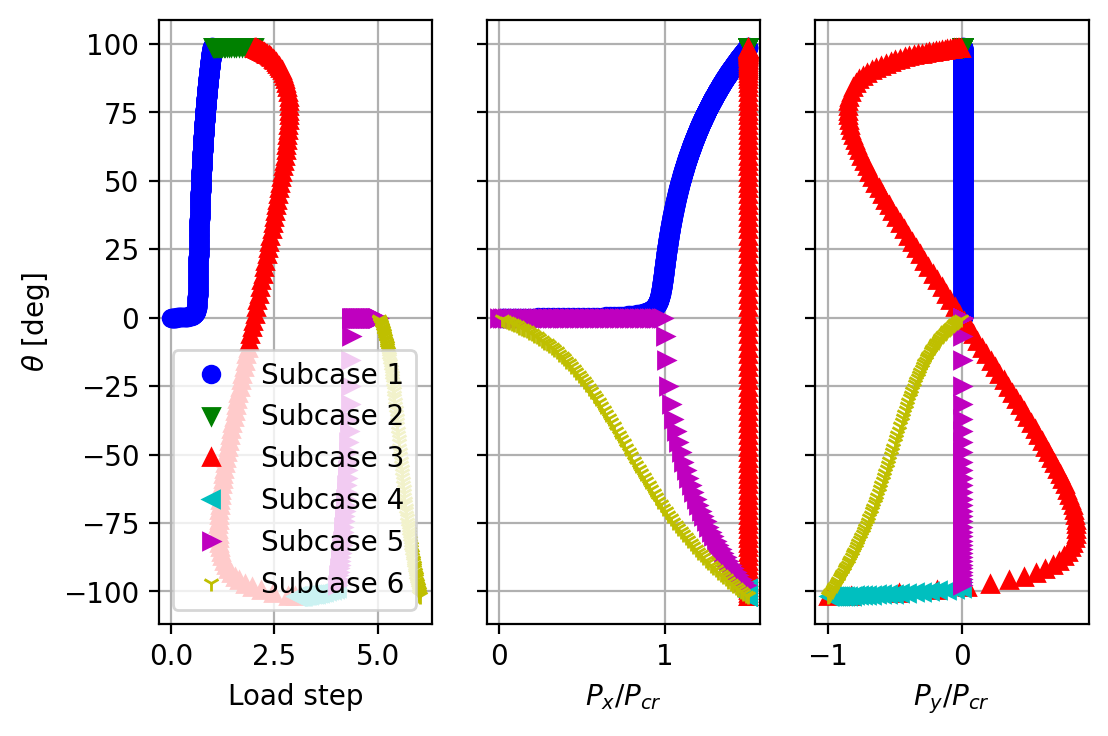

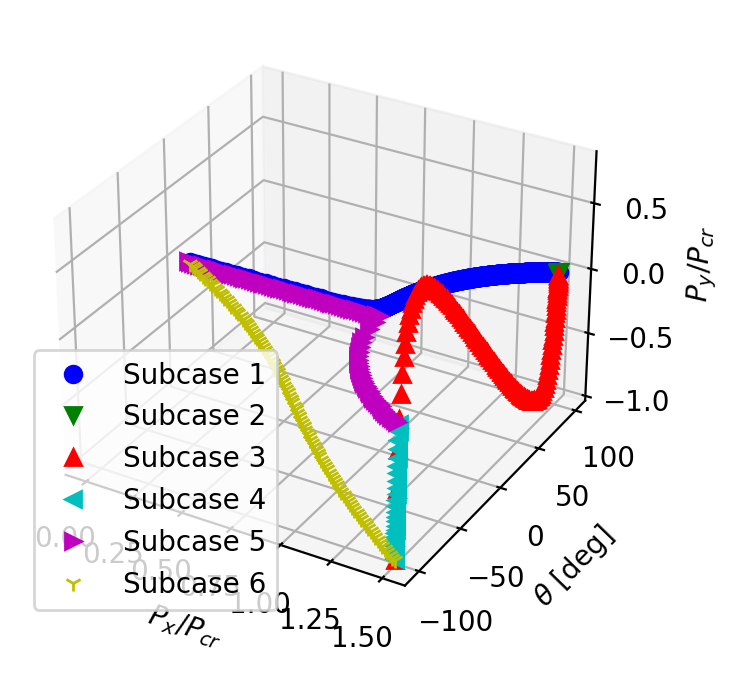

In [144]:
# Run analysis
utils.run_analysis(analysis_directory_path, alternative_subcases_model, reduced_compression_force_model_name, run_flag=False)
# Define name of op2 file
op2_file_path = os.path.join(analysis_directory_path, reduced_compression_force_model_name + '.op2')
# Get output data from op2 file
load_step, rotation_rad, applied_load_x, applied_load_y = utils.read_equilibrium_path_data_from_op2(op2_file_path, displacement_node_id=1, displacement_index=5, load1_index=0, load2_index=1)
# Convert rotation angles from radians to degrees
rotation_deg = {k:np.rad2deg(v) for k, v in rotation_rad.items()}
# Plot 2d results
plot_2d_equilibrium_paths(rotation_deg, load_step, applied_load_x, applied_load_y)
# Plot 3d results
plot_3d_equilibrium_paths(rotation_deg, applied_load_x, applied_load_y)

We can observe the following features.
* Broken pitchfork on the side corresponding to upward deflection of the column described in subcase 1.
* Snap-through behavior highlighted by subcase 3.
* Equal and opposite $\theta$ between subcase 2 and 4.
* Pristine pitchfork on the side corresponding to downward deflection of the column described in subcase 5.
* Broken pitchfork on the side corresponding to downward deflection of the column described in subcase 6. We can notice that the curve in the $P_x/P_{cr}$-$\theta$ plot is more distant from the bifurcation point with respect to the broken pitchfork curve described by subcase 1. This is caused by the different magnitude of the transverse load.
* Equal value of $\theta$ between subcase 3 and 6.

All these results are in line with the expectations.

## Conclusions <a name="conclusions"></a>
We can draw the following conclusions regarding the use of the arc-length method in Nastran.
* The order of subcases matters to get to a specific point of the equilibrium diagram.
* The arc-length method has issues when the subcase applies a load in the opposite direction with respect to the one of the previous subcase. In these situations, the Newton method should be used.